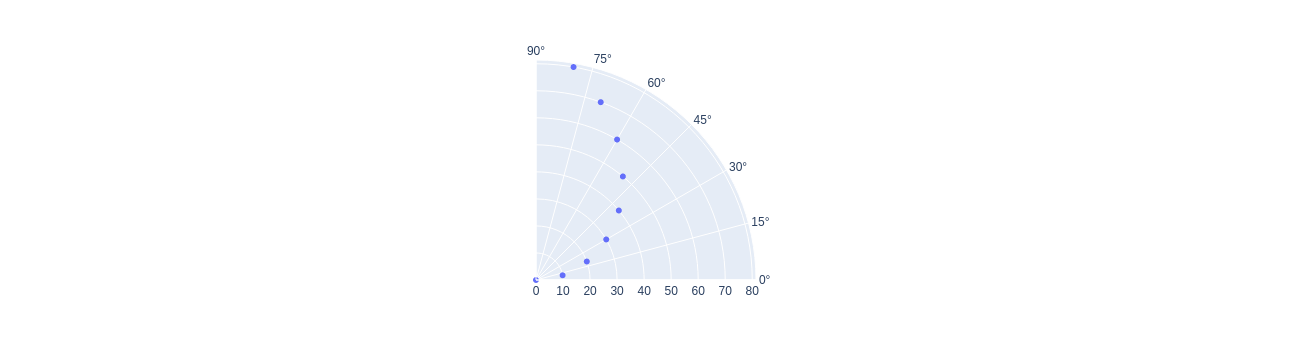

In [123]:
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

fig = px.scatter_polar(r=range(0,90,10), theta=range(0,90,10),
                       range_theta=[0,90], start_angle=0, direction="counterclockwise")
fig.show()


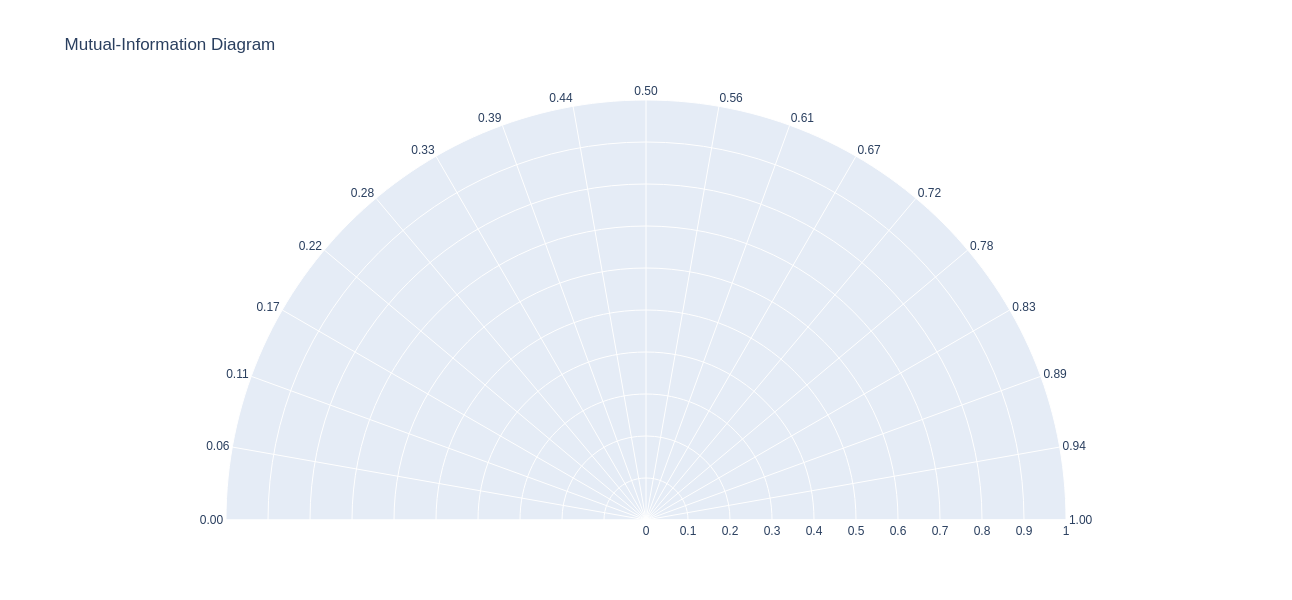

In [124]:
# range_r is adaptable to the data (entropy between models)

# TODO: Create a synthetic dataset and plot the models on the diagram
# Check if everything works correctly

chart_base = px.scatter_polar(
    range_r=[0, 1],
    title='Mutual-Information Diagram',
    
)

list_angular_ticks = [i for i in range(-360, -170, 10)]
list_angular_labels = ["{:.2f}".format(i)
                       for i in np.linspace(0, 1, len(list_angular_ticks))]

chart_base.update_layout(
    polar = dict(
        sector = [0, 180],
        angularaxis = dict(
            thetaunit = "degrees",
            #dtick = 45,
            rotation=180,
            direction = "clockwise",
            tickmode="array",
            tickvals=list_angular_ticks,
            ticktext=list_angular_labels
            )
    ),
    height=600
)

chart_base.show()

In [125]:
path_root_data = os.path.join('..', 'Data')
path_anscombes_quartet = os.path.join(path_root_data, 'Anscombes_Quartet.csv')

df_anscombes_quartet = pd.read_csv(path_anscombes_quartet)
df_anscombes_quartet

,x1,y1,x2,y2,x3,y3,x4,y4
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47
5,14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04
6,6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25
7,4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50
8,12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56
9,7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91


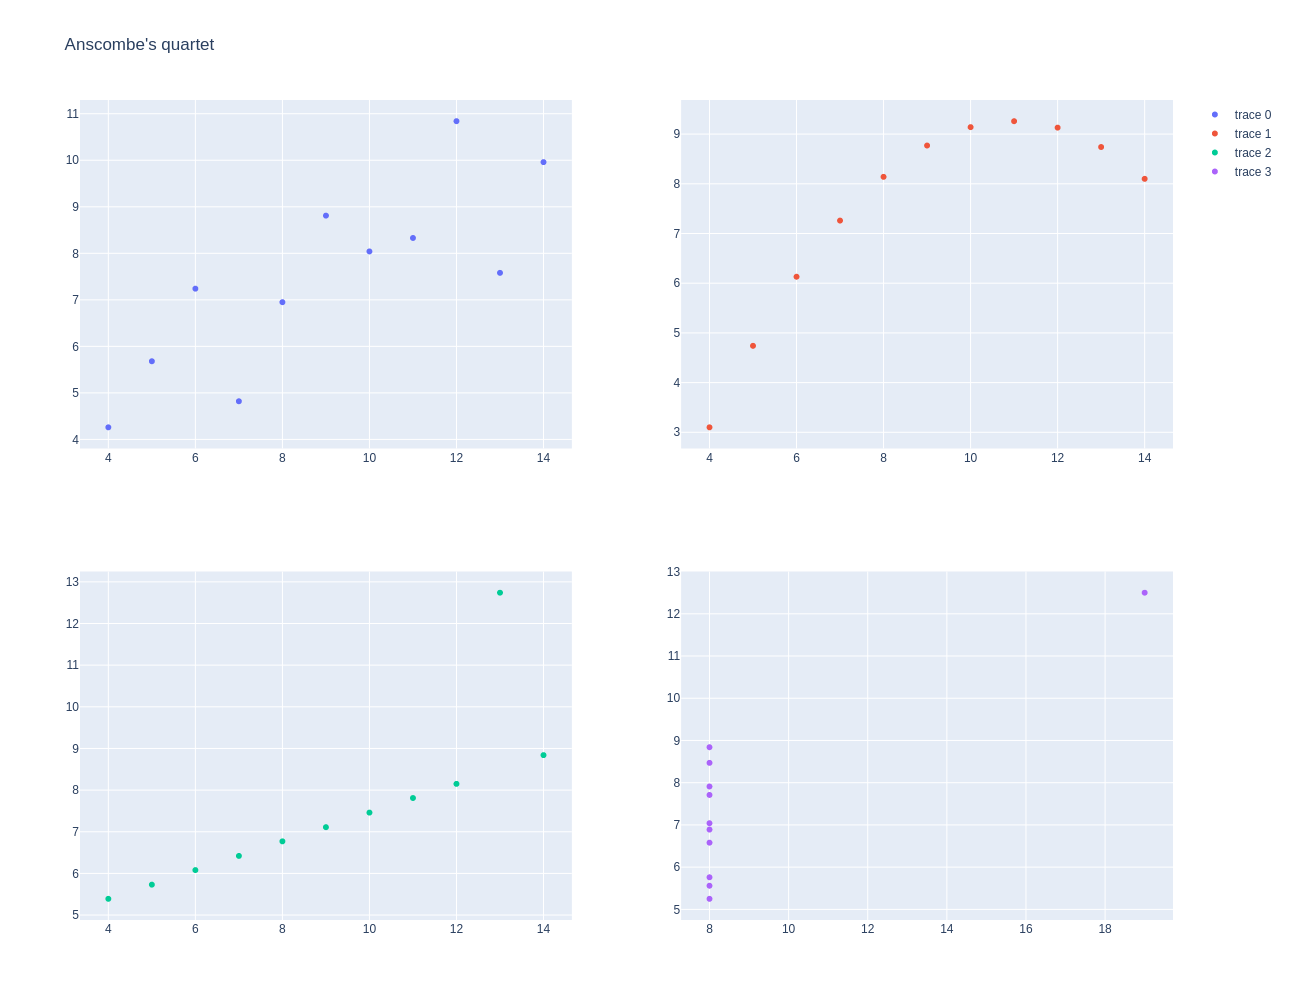

In [126]:
def chart_scatter_anscombes_quartet(df_input):
    
    chart_result = make_subplots(rows=2, cols=2)

    chart_result.add_trace(
        go.Scatter(x=df_input['x1'], y=df_input['y1'], mode="markers"),
        row=1, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x2'], y=df_input['y2'], mode="markers"),
        row=1, col=2
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x3'], y=df_input['y3'], mode="markers"),
        row=2, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x4'], y=df_input['y4'], mode="markers"),
        row=2, col=2
    )
    
    chart_result.update_layout(height=1000, title_text="Anscombe's quartet")
    
    return chart_result


chart_anscombes = chart_scatter_anscombes_quartet(df_anscombes_quartet)
chart_anscombes.show()
    

In [127]:
df_anscombes_quartet.columns.to_list()

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']

In [128]:
df_anscombes_quartet_modified = df_anscombes_quartet.drop(
    ['x1', 'x2', 'x3', 'x4'], axis=1)
df_anscombes_quartet_modified

,y1,y2,y3,y4
0,8.04,9.14,7.46,6.58
1,6.95,8.14,6.77,5.76
2,7.58,8.74,12.74,7.71
3,8.81,8.77,7.11,8.84
4,8.33,9.26,7.81,8.47
5,9.96,8.10,8.84,7.04
6,7.24,6.13,6.08,5.25
7,4.26,3.10,5.39,12.50
8,10.84,9.13,8.15,5.56
9,4.82,7.26,6.42,7.91


In [210]:
import math
from sklearn.neighbors import KernelDensity
from shannon import continuous
from npeet import entropy_estimators
from scipy.stats import differential_entropy
from sklearn.feature_selection import mutual_info_regression


# TODO: Find out how to calculate probabilities properly
# Or use Kraskov (or https://www.biorxiv.org/content/10.1101/589929v2-0.full)
# to calculate MI and entropy without extra steps.

# TODO: Check out how shannon library uses KNN for probability estimation
# and replicate that by using sklearn. If the results are the same, then do the
# same procedure for KDE as in the paper. This is not urgent, but it is
# necessary for the final product

# Implement bookmarked solutions for entropy and MI estimation
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html?highlight=entropy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.differential_entropy.html
# https://github.com/paulbrodersen/entropy_estimators/
# https://github.com/gregversteeg/NPEET <- USE THIS ONE FIRST !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# https://github.com/BiuBiuBiLL/NPEET_LNC <- And this one second (an improvement)

def estimate_pdf_using_kde(list_samples):
    
    list_samples_modified = list_samples.to_numpy()[:, np.newaxis]
    
    model_kde = KernelDensity(kernel='gaussian', bandwidth=3.47)
    model_kde.fit(list_samples_modified)
    list_log_probabilities = model_kde.score_samples(list_samples_modified)
    list_probabilities = np.exp(list_log_probabilities)
    
    return list_probabilities


def calculate_td_properties(df_input, string_reference_feature,
                             string_method='pearson'):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    # IMPORTANT NOTE: Authors of MID paper were using correlation corr(xi,yi)
    # for i in {1,2,3,4} instead of corr(y4, yi) for i in {1,2,3}
    # That is why my plot is different. Their example is bad since in MID
    # they are comparing different yi for fixed x (time-series)
    # and for Taylor diagram they did the opposite in order to create an example
    # that fits their narrative
    
    for string_one_feature in list_all_features:
        # Calculating standard deviations
        dict_result[string_one_feature].append(
            df_input[string_one_feature].std())
        
        # Calculating Pearson's correlation
        dict_result[string_one_feature].append(
            df_input[string_reference_feature].corr(
                df_input[string_one_feature], method=string_method))
        
        # Calculate arccos of Pearson's correlation
        dict_result[string_one_feature].append(math.degrees(
            math.acos(dict_result[string_one_feature][-1])))
    
    # Calculating normalized standard deviation
    for string_one_feature in list_all_features:
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] / dict_result[
                string_reference_feature][0])
    
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        columns=['STD', 'Correlation', 'Angle', 'Normalized_STD'])
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
    
    return df_result



def calculate_mid_properties_shannon(df_input, string_reference_feature,
                                     string_method='nearest-neighbors'):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    for string_one_feature in list_all_features:
        # Calculate entropies
        dict_result[string_one_feature].append(
            continuous.entropy(
                data=df_input[string_one_feature].to_numpy().reshape(-1, 1),
                method=string_method)
        )
        
        # Calculate mutual informations against the reference feature
        dict_result[string_one_feature].append(
            continuous.mi(
                x=df_input[string_reference_feature].to_numpy().reshape(-1, 1),
                y=df_input[string_one_feature].to_numpy().reshape(-1, 1),
                method=string_method)
        )
        
    
    for string_one_feature in list_all_features:
        # Calculate scaled entropies
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] /
            dict_result[string_reference_feature][0]
        )
    
        # Calculate joint entropies
        array_x = df_input[string_reference_feature].to_numpy().reshape(-1, 1)
        array_y = df_input[string_one_feature].to_numpy().reshape(-1, 1)
        
        try:
            # handling for 1d np arrays
            if len(array_x.shape) == 1:
                array_x = np.expand_dims(array_x, 1)
            if len(array_y.shape) == 1:
                array_y = np.expand_dims(array_y, 1)
        except:
            pass
        
        dict_result[string_one_feature].append(
            continuous.entropy(
                data=np.concatenate([array_x, array_y], axis=1),
                method=string_method)
        )
        
        # TODO: Check why scaled mutual information is not 1 for the reference
        # value and fix so that it is 1. Equations 15 and 17 from the paper are
        # relevant for this issue.
        
        # Calculate normalized mutual information according to the paper
        # NMI(X,Y) = I(X,Y) / sqrt(H(X) * H(Y))
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][1] /
            math.sqrt(dict_result[string_reference_feature][0] *
                      dict_result[string_one_feature][0])
        )
        
        # TODO: Should I use the equation below somewhere?
        # I(X,Y) = I^(X,Y) * ((H(X) / I^(X,X)) (equation 17)
        # where I^(X,Y) is estimated MI using some density estimation algorithm
        
    
    for string_one_feature in list_all_features:
        # Calculate scaled mutual information according to the paper
        # SMI(X,Y) = I(X,Y) * ((H(X,Y) / (H(X)*H(Y)))) (equation 15)
        # where I(X,Y) is normalized MI from equation 17 (probably, check)
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][4] *
            (dict_result[string_one_feature][3] /
             (dict_result[string_reference_feature][0] *
              dict_result[string_one_feature][0]))
        )
        
        # Calculate arccos of biased scaled mutual information according to the paper
        # arccos(c(X,Y)) where c(X,Y) = 2*I^(X,Y) * (H(X,Y)/(H(X)*H(Y))) - 1
        #c_x_y = 2*dict_result[string_one_feature][1] * (
        #    dict_result[string_one_feature][2] /
        #    (dict_result[string_reference_feature][0]
        #     * dict_result[string_one_feature][0])) - 1
        
        #dict_result[string_one_feature].append(math.degrees(math.acos(c_x_y)))
    
    ##########################################################
    # BUG: Gives math domain error when calculating angle because MI is negative
    ##########################################################
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        columns=['Entropy', 'Mutual_information', 'Scaled_entropy',
                 'Joint_entropy', 'Normalized_MI', 'Scaled_MI'])#, 'Angle'])
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
    
    print('Mutual Information')
    print(df_result)
    
    
    return df_result


def list_adapt_to_npeet(list_input):
    return [[i] for i in list_input]


def calculate_mid_properties_npeet(df_input, string_reference_feature):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    list_adapted_npeet_reference = list_adapt_to_npeet(
        df_input[string_reference_feature])
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    for string_one_feature in list_all_features:
        list_adapted_npeet_one = list_adapt_to_npeet(
            df_input[string_one_feature])
        
        # Calculate entropies
        # 0 in the list
        dict_result[string_one_feature].append(
            entropy_estimators.entropy(list_adapted_npeet_one))
        
        # Calculate mutual informations against the reference feature
        # 1 in the list
        dict_result[string_one_feature].append(
            entropy_estimators.mi(list_adapted_npeet_reference,
                                  list_adapted_npeet_one))
        
    
    for string_one_feature in list_all_features:
        # Calculating fixed MI from equation 17 from the paper
        # I(X,Y) = I~(X,Y) * (H(X) / I~(X,X)) where I~ is MI calculated using
        # some estimation method. This MI is used for every calculation
        # afterwards
        # 2 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][1] *
            (dict_result[string_reference_feature][0] /
             dict_result[string_reference_feature][1])
        )
        
        # Calculate scaled entropies
        # 3 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] /
            dict_result[string_reference_feature][0]
        )

        # Calculate normalized mutual information according to the paper
        # NMI(X,Y) = I(X,Y) / sqrt(H(X) * H(Y))
        # 4 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][2] /
            math.sqrt(dict_result[string_reference_feature][0] *
                      dict_result[string_one_feature][0])
        )
        
        # Calculate arccos of normalized mutual information according to the
        # paper arccos(NIM(X,Y))
        # 5 in the list
        dict_result[string_one_feature].append(
            math.degrees(math.acos(dict_result[string_one_feature][4])))
    
    
    for string_one_feature in list_all_features:
        ######################################################################
        # This part is for the chart that spans two quadrants
        
        # First calculate joint entropies by using equation 10 from the paper
        # I(X,Y) = H(X) + H(Y) - H(X,Y) => H(X,Y) = H(X) + H(Y) - I(X,Y)
        # 6 in the list
        dict_result[string_one_feature].append(
            dict_result[string_reference_feature][0] +
            dict_result[string_one_feature][0] -
            dict_result[string_one_feature][2]
        )
        
        # Calculate scaled mutual information according to the paper
        # SMI(X,Y) = I(X,Y) * ((H(X,Y) / (H(X)*H(Y)))) (equation 15)
        # 7 in the list
        smi_x_y = dict_result[string_one_feature][2] * (
            dict_result[string_one_feature][6] /
            (dict_result[string_reference_feature][0]
             * dict_result[string_one_feature][0]))
        
        dict_result[string_one_feature].append(smi_x_y)
        
        # Calculate arccos of biased scaled mutual information according to the paper
        # arccos(c(X,Y)) where c(X,Y) = 2*SMI(X,Y) - 1
        # 8 in the list
        #dict_result[string_one_feature].append(
        #    math.degrees(math.acos(2*smi_x_y - 1)))
        
        ######################################################################
    
    ##########################################################
    # BUG: Gives math domain error when calculating angle because MI is negative
    ##########################################################
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        columns=['Entropy', 'Mutual_information', 'Fixed_MI', 'Scaled_entropy',
                 'Normalized_MI', 'Angle_NMI', 'Joint_entropies', 'Scaled_MI',
                 ])#'Angle_SMI'])
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
        
    return df_result


def calculate_mid_properties(df_input, string_reference_feature):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    for string_one_feature in list_all_features:
        # Calculate entropies
        # 0 in the list
        dict_result[string_one_feature].append(
            differential_entropy(df_input[string_one_feature], base=2))
        
        # Calculate mutual informations against the reference feature
        # 1 in the list
        dict_result[string_one_feature].append(
            mutual_info_regression(
                df_input[string_reference_feature].to_numpy().reshape(-1, 1),
                df_input[string_one_feature],
                discrete_features=False)[0])
        
    
    for string_one_feature in list_all_features:
        # Calculating fixed MI from equation 17 from the paper
        # I(X,Y) = I~(X,Y) * (H(X) / I~(X,X)) where I~ is MI calculated using
        # some estimation method. This MI is used for every calculation
        # afterwards
        # 2 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][1] *
            (dict_result[string_reference_feature][0] /
             dict_result[string_reference_feature][1])
        )
        
        # Calculate scaled entropies
        # 3 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] /
            dict_result[string_reference_feature][0]
        )

        # Calculate normalized mutual information according to the paper
        # NMI(X,Y) = I(X,Y) / sqrt(H(X) * H(Y))
        # This has to be modified because H(X)*H(Y) can be negative for
        # differential entropies. NMI is not used at all for the MI chart
        # that spans two quadrants
        # 4 in the list
        float_product = dict_result[string_reference_feature][0] *\
            dict_result[string_one_feature][0]
        
        if float_product < 0:
            dict_result[string_one_feature].append(1)
        
        else:
            dict_result[string_one_feature].append(
                dict_result[string_one_feature][2] / math.sqrt(float_product))
        
        # Calculate arccos of normalized mutual information according to the
        # paper arccos(NIM(X,Y))
        # 5 in the list
        dict_result[string_one_feature].append(
            math.degrees(math.acos(dict_result[string_one_feature][4])))
    
    
    for string_one_feature in list_all_features:
        ######################################################################
        # This part is for the chart that spans two quadrants
        
        # First calculate joint entropies by using equation 10 from the paper
        # I(X,Y) = H(X) + H(Y) - H(X,Y) => H(X,Y) = H(X) + H(Y) - I(X,Y)
        # 6 in the list
        dict_result[string_one_feature].append(
            dict_result[string_reference_feature][0] +
            dict_result[string_one_feature][0] -
            dict_result[string_one_feature][2]
        )
        
        # Calculate scaled mutual information according to the paper
        # SMI(X,Y) = I(X,Y) * ((H(X,Y) / (H(X)*H(Y)))) (equation 15)
        # 7 in the list
        smi_x_y = dict_result[string_one_feature][2] * (
            dict_result[string_one_feature][6] /
            (dict_result[string_reference_feature][0]
             * dict_result[string_one_feature][0]))
        
        dict_result[string_one_feature].append(smi_x_y)
        
        # Calculate arccos of biased scaled mutual information according to the paper
        # arccos(c(X,Y)) where c(X,Y) = 2*SMI(X,Y) - 1
        # 8 in the list
        float_c_x_y = 2*smi_x_y - 1
        
        if float_c_x_y > 1:
            dict_result[string_one_feature].append(
                math.degrees(math.acos(1)))
        elif float_c_x_y < -1:
            dict_result[string_one_feature].append(
            math.degrees(math.acos(-1)))
        else:
            dict_result[string_one_feature].append(
                math.degrees(math.acos(2*smi_x_y - 1)))
        
        ######################################################################
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        columns=['Entropy', 'Mutual_information', 'Fixed_MI', 'Scaled_entropy',
                 'Normalized_MI', 'Angle_NMI', 'Joint_entropies', 'Scaled_MI',
                 'Angle_SMI'])
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
    
    return df_result



def chart_create_mid(df_input, string_reference_feature,
                     string_type='normalized'):
    
    if string_type == 'scaled':
        list_angular_ticks = [i for i in range(0, 190, 10)]
        list_sector = [0, 180]
        string_mi = 'Scaled_MI'
        string_angle = 'Angle_SMI'
    
    elif string_type == 'normalized':
        list_angular_ticks = [i for i in range(0, 100, 10)]
        list_sector = [0, 90]
        string_mi = 'Normalized_MI'
        string_angle = 'Angle_NMI'
        
    else:
        print('Type has to be either "scaled" or "normalized"')
    
    list_angular_labels = ["{:.2f}".format(i)
                           for i in
                           np.linspace(0, 1, len(list_angular_ticks))][::-1]
    
    float_max_r = df_input['Entropy'].max() + df_input['Entropy'].mean()
    
    chart_result = px.scatter_polar(
        data_frame=df_input,
        start_angle=0,
        color='Model',
        r='Entropy',
        range_r=[0, float_max_r],
        theta=string_angle,
        title='Mutual Information Diagram',
        #labels={'Entropy': 'Entropy', 'Normalized MI': 'NMI'}

    )

    chart_result.update_layout(
        polar = dict(
            sector = list_sector,
            angularaxis = dict(
                #thetaunit = "degrees",
                dtick = 10,
                #rotation=270,
                direction = "counterclockwise",
                #tickmode="array",
                tickvals=list_angular_ticks,
                ticktext=list_angular_labels
                )
        ),
        height=600
    )
    
    chart_result.update_polars(
        radialaxis_title_text='Entropy',
    )
    
    return chart_result


def chart_create_td(df_input, string_reference_feature):
    
    string_r_column = 'STD'
    float_max_r = df_input[string_r_column].max() +\
        df_input[string_r_column].mean()
    
    chart_result = px.scatter_polar(
        data_frame=df_input,
        start_angle=0,
        color='Model',
        r=string_r_column,
        range_r=[0, float_max_r],
        theta='Angle',
        title='Taylor Diagram',
        #labels={'Normalized_STD': 'Normalized STD', 'Angle': 'Correlation'}
    )
    
    bool_only_half = True if (df_input['Correlation'] > 0).all() else False
    int_max_angle = 90 if bool_only_half else 180
    int_min_corr_value = 0 if bool_only_half else -1
    
    list_angular_ticks = [i for i in range(0, int_max_angle + 10, 10)]
    list_angular_labels = ["{:.2f}".format(i)
                           for i in np.linspace(int_min_corr_value,
                                                1,
                                                len(list_angular_ticks))][::-1]
    
    # TODO: Check how to fix correlation position of models on diagram
    # I have to use arccos(corr_value) to get an angle probably
    
    chart_result.update_layout(
        polar = dict(
            sector=[0, int_max_angle],
            angularaxis=dict(
                #thetaunit = "degrees",
                dtick=10,
                #rotation=270,
                direction="counterclockwise",
                #tickmode="array",
                #tickvals=list_angular_ticks,
                #ticktext=list_angular_labels,
            ),
        ),
        height=600
    )
    
    chart_result.update_polars(
        radialaxis_title_text=string_r_column,
    )
    
    return chart_result


string_ref_model = 'y4'
string_type_mid = 'scaled'


df_taylor_res = calculate_td_properties(df_anscombes_quartet_modified, string_ref_model, string_method='pearson')
print('Taylor')
df_taylor_res

Taylor


,Model,STD,Correlation,Angle,Normalized_STD
0,y1,2.031568,-0.489116,119.282510,1.000487
1,y2,2.031657,-0.478095,118.561047,1.000531
2,y3,2.030424,-0.155472,98.944159,0.999924
3,y4,2.030579,1.000000,0.000000,1.000000


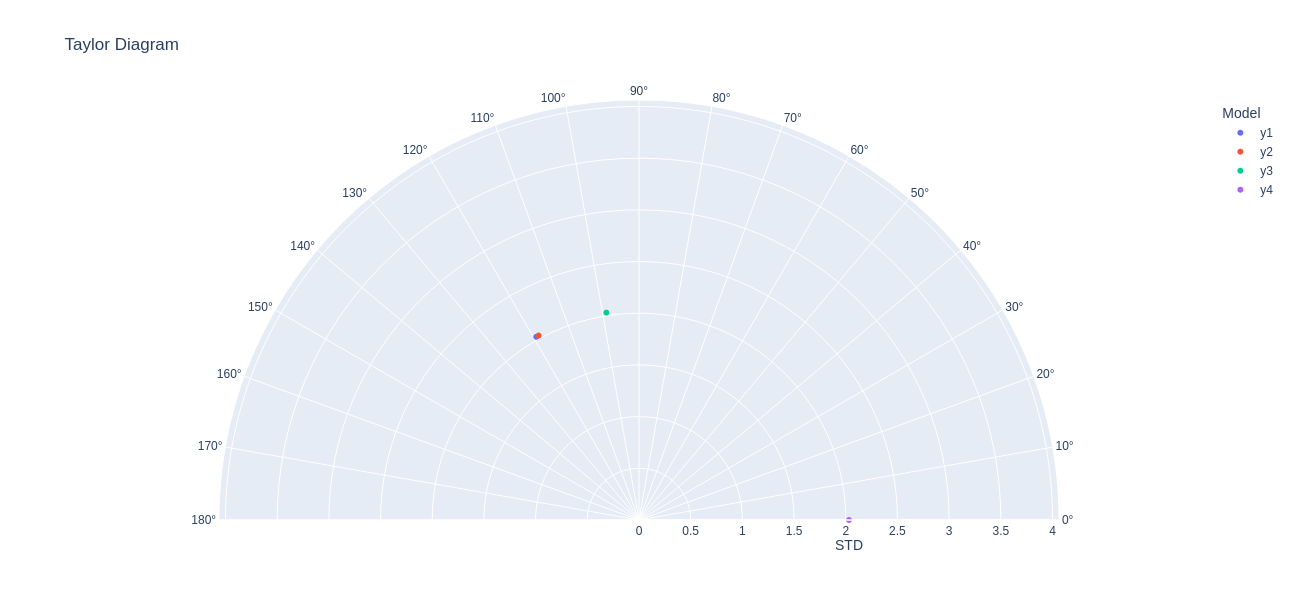

In [211]:
chart_taylor_res = chart_create_td(df_taylor_res, string_ref_model)
chart_taylor_res.show()

In [196]:
#df_mi_res_shannon = calculate_mid_properties_shannon(df_anscombes_quartet_modified, string_ref_model)#, string_method='gaussian')

print('Mutual Information NPEET')
df_mi_res_npeet = calculate_mid_properties_npeet(df_anscombes_quartet_modified, string_ref_model)
df_mi_res_npeet

Mutual Information NPEET


,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI
0,y1,3.389044,-0.024565,-0.048125,1.094441,-0.014855,90.851188,6.533767,-0.029962
1,y2,2.753054,-0.026647,-0.052203,0.889057,-0.017879,91.024452,5.901855,-0.036140
2,y3,2.929475,-0.071406,-0.139888,0.946030,-0.046445,92.662082,6.165961,-0.095084
3,y4,3.096598,1.580667,3.096598,1.000000,1.000000,0.000000,3.096598,1.000000


In [197]:
print('Mutual Information DEFAULT')
df_mi_res = calculate_mid_properties(df_anscombes_quartet_modified, string_ref_model)
df_mi_res

Mutual Information DEFAULT


,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI
0,y1,2.852820,0.000000,0.000000,1.052292,0.0,90.0,5.563874,0.0,180.0
1,y2,2.312211,0.000000,0.000000,0.852883,0.0,90.0,5.023265,0.0,180.0
2,y3,2.618974,0.000000,0.000000,0.966036,0.0,90.0,5.330028,0.0,180.0
3,y4,2.711054,1.095635,2.711054,1.000000,1.0,0.0,2.711054,1.0,0.0


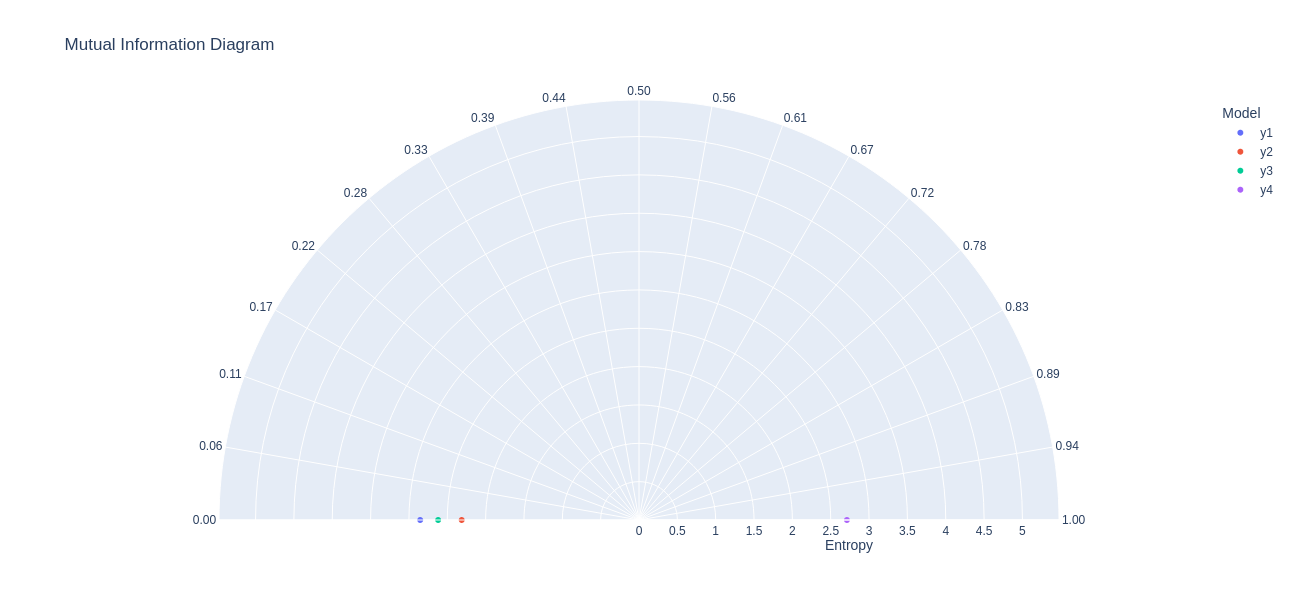

In [198]:
chart_mi_res = chart_create_mid(df_mi_res, string_ref_model, string_type=string_type_mid)
chart_mi_res.show()

In [199]:
import cftime
import datetime as dt
import xarray
from netCDF4 import Dataset, date2index, num2date, date2num

def test_dataset_1():
    
    # IMPORTANT
    ###########################################################################
    # How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
    # Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts
    ###########################################################################
    
    path_root_data = os.path.join('..', 'Data')
    path_dataset_1 = os.path.join(path_root_data, 'Dataset_1', 'Files')
    
    float_kelvin = 273.15
    
    list_datetimes = []
    list_temperatures = []
    list_models = []
    
    # Each name is encoded as a directory name
    list_model_names = [i for i in os.listdir(path_dataset_1)
                        if os.path.isdir(os.path.join(path_dataset_1, i))]
    
    for i, string_one_model in enumerate(list_model_names):
        path_one_model_dir = os.path.join(path_dataset_1, string_one_model)
        
        if string_one_model in ['ncar_ccsm3_0', 'mri_cgcm2_3_2a']:
            continue
        
        # TODO: I have to traverse each directory and then combine multiple
        # files since some models have more than one files for this experiment
        for j, string_one_model_file in enumerate(os.listdir(path_one_model_dir)):
        
            path_one_model_file = os.path.join(
                path_one_model_dir, string_one_model_file)
            
            ds_one_model_file = xarray.open_dataset(
                path_one_model_file, decode_times=True, use_cftime=True)
            
            try:
                # Time slicing for the 20th century
                ds_one_model_file_20th_century = ds_one_model_file.sel(
                    time=slice('1900-01-01','2000-01-01'))

                # Anual resampling
                ds_one_model_file_20th_century_mean = ds_one_model_file_20th_century.resample(time='AS').mean()

                ds_one_model_file_temperature = ds_one_model_file_20th_century_mean.variables['ts'].to_numpy()
                ds_one_model_file_time = ds_one_model_file_20th_century_mean.indexes['time'].to_datetimeindex()

                list_datetimes += ds_one_model_file_time.tolist()

                # Taking geographicall mean besides temporal
                np_tmp_temp = np.array(ds_one_model_file_temperature)
                list_geographically_mean_temperatures = np_tmp_temp.mean(axis=(1,2)).tolist()
                list_temperatures += list_geographically_mean_temperatures

                list_models += [string_one_model] * len(list_geographically_mean_temperatures)
            
            except:
                continue
    
    df_dataset_1 = pd.DataFrame(
        {'Datetime': list_datetimes, 'Temperature': list_temperatures,
         'Model': list_models})
    
    return df_dataset_1


df_dataset_1 = test_dataset_1()
df_dataset_1

/tmp/ipykernel_12557/3344637067.py:55: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_12557/3344637067.py:55: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_12557/3344637067.py:55: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_12557/3344637067.py:55: RuntimeWarning:

Converting a CFTimeIndex with dates from a 

,Datetime,Temperature,Model
0,1900-01-01,277.076477,inmcm3_0
1,1901-01-01,277.123596,inmcm3_0
2,1902-01-01,277.183899,inmcm3_0
3,1903-01-01,277.028564,inmcm3_0
4,1904-01-01,277.259094,inmcm3_0
...,...,...,...
2195,1995-01-01,277.791870,ukmo_hadcm3
2196,1996-01-01,277.680725,ukmo_hadcm3
2197,1997-01-01,277.992981,ukmo_hadcm3
2198,1998-01-01,277.921051,ukmo_hadcm3


In [200]:
df_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     2200 non-null   datetime64[ns]
 1   Temperature  2200 non-null   float64       
 2   Model        2200 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.7+ KB


In [201]:
df_dataset_1['Model'].unique()

array(['inmcm3_0', 'cccma_cgcm3_1_t63', 'ingv_echam4', 'iap_fgoals1_0_g',
       'miub_echo_g', 'giss_model_e_h', 'gfdl_cm2_1', 'giss_model_e_r',
       'bccr_bcm2_0', 'csiro_mk3_0', 'ukmo_hadgem1', 'gfdl_cm2_0',
       'mpi_echam5', 'miroc3_2_medres', 'ncar_pcm1', 'csiro_mk3_5',
       'giss_aom', 'miroc3_2_hires', 'ipsl_cm4', 'cccma_cgcm3_1',
       'cnrm_cm3', 'ukmo_hadcm3'], dtype=object)

In [202]:
len(df_dataset_1['Model'].unique())

22

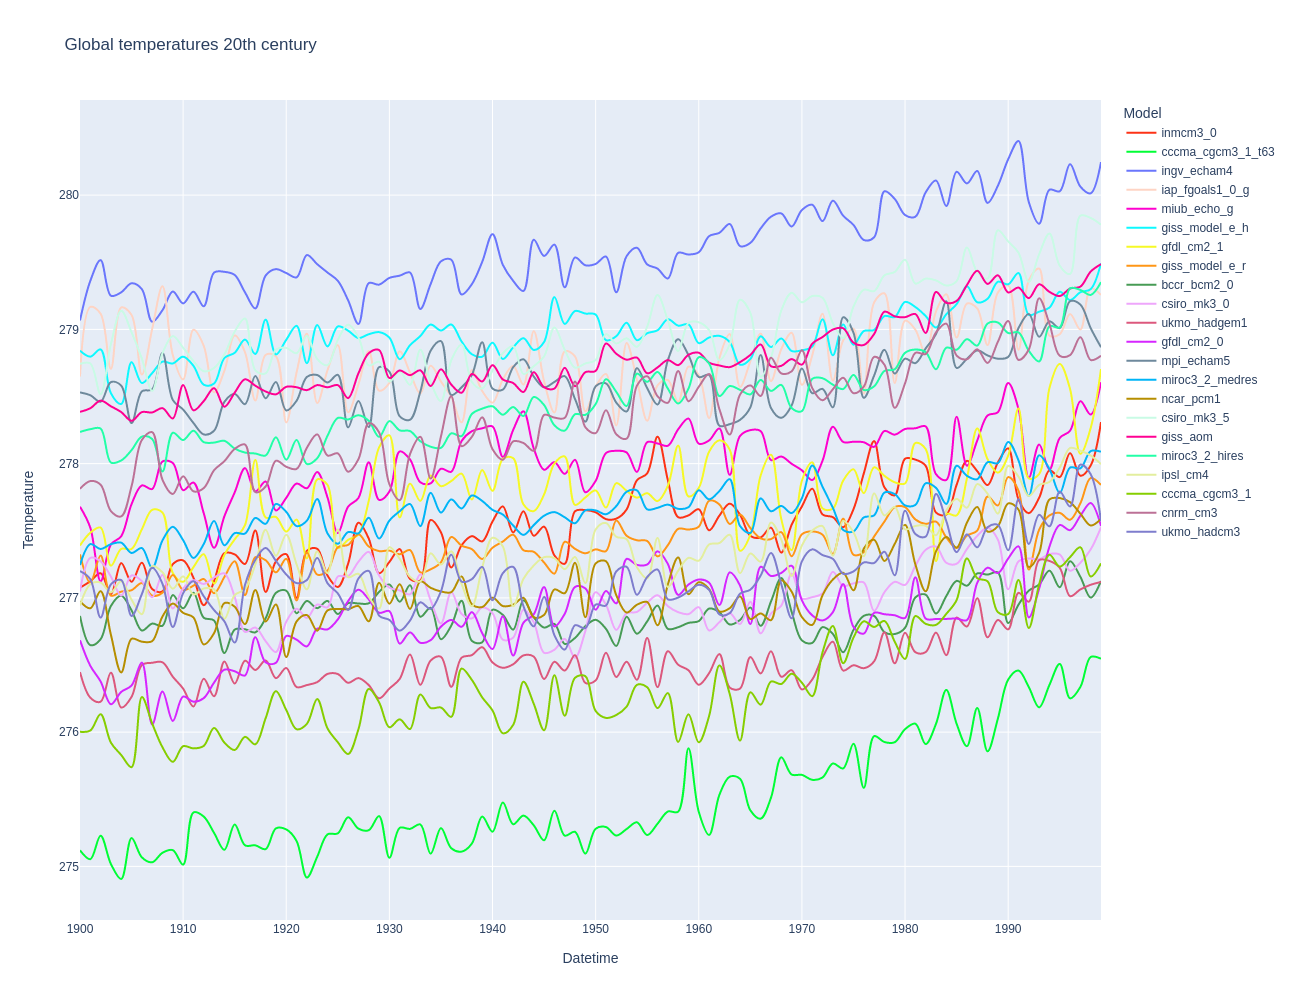

In [203]:
fig = px.line(df_dataset_1, x='Datetime', y='Temperature', color='Model',
              title='Global temperatures 20th century', render_mode='svg',
              line_shape='spline',
              color_discrete_sequence=px.colors.qualitative.Light24,)
fig.update_layout(height=1000)
fig.show()

In [204]:
df_dataset_1_pivoted = pd.pivot(df_dataset_1, index=['Datetime'], columns=['Model'], values=['Temperature']).reset_index(drop=True)
df_dataset_1_pivoted.columns = df_dataset_1_pivoted.columns.get_level_values(1)
df_dataset_1_pivoted

Model,bccr_bcm2_0,cccma_cgcm3_1,cccma_cgcm3_1_t63,cnrm_cm3,csiro_mk3_0,csiro_mk3_5,gfdl_cm2_0,gfdl_cm2_1,giss_aom,giss_model_e_h,...,ingv_echam4,inmcm3_0,ipsl_cm4,miroc3_2_hires,miroc3_2_medres,miub_echo_g,mpi_echam5,ncar_pcm1,ukmo_hadcm3,ukmo_hadgem1
0,276.865601,276.002563,275.119843,277.812378,277.047333,278.742828,276.684692,277.390442,278.385315,278.841309,...,279.066498,277.076477,276.943085,278.235901,277.244904,277.678986,278.530609,276.974762,277.199677,276.447510
1,276.648376,276.011749,275.053864,277.870117,277.297546,278.746216,276.494141,277.485474,278.412415,278.796906,...,279.361145,277.123596,277.102478,278.256470,277.400635,277.522614,278.509583,276.922485,277.139191,276.256592
2,276.692078,276.133514,275.228760,277.842987,277.272705,278.516357,276.377502,277.523804,278.469360,278.850769,...,279.515869,277.183899,277.114075,278.261261,277.363922,277.123749,278.461151,277.050232,276.853088,276.226593
3,276.940002,275.921570,275.017639,277.646393,277.158569,278.891052,276.207672,277.239960,278.427094,278.524261,...,279.250458,277.028564,277.040771,278.007935,277.399963,277.397949,278.607269,276.724640,277.101227,276.443298
4,277.016418,275.829468,274.906097,277.607147,277.016510,279.138519,276.300018,277.364685,278.384064,278.444336,...,279.276093,277.259094,277.124786,278.023560,277.411346,277.459534,278.580688,276.444580,277.132538,276.183167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,277.078735,277.233032,276.508240,278.803253,277.323029,279.473785,277.543152,278.742798,279.248108,279.280243,...,280.028534,277.899567,277.970917,279.014557,277.781433,278.191223,279.009399,277.743652,277.791870,277.224091
96,277.273438,277.303558,276.251526,278.808105,277.202087,279.412689,277.504211,278.555969,279.304291,279.218414,...,280.230988,278.078400,278.116333,279.305420,277.970764,278.244751,279.209564,277.712982,277.680725,277.012482
97,277.156433,277.377502,276.336853,278.942139,277.261566,279.846802,277.612183,278.072968,279.318207,279.276794,...,280.062958,277.909790,278.096161,279.293823,277.964844,278.465179,279.184357,277.626801,277.992981,277.063293
98,277.002075,277.158752,276.559875,278.771912,277.361115,279.829834,277.706665,278.265320,279.430756,279.299530,...,280.013428,277.985931,278.060577,279.256287,278.093384,278.365509,279.009308,277.539246,277.921051,277.097687


In [205]:
df_dataset_1_mid = calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0')
df_dataset_1_mid

,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI
0,bccr_bcm2_0,-0.731772,3.344044,-0.731772,1.000000,-1.000000,180.000000,-0.731772,1.000000,0.000001
1,cccma_cgcm3_1,0.491545,0.200957,-0.043975,-0.671718,1.000000,0.000000,-0.196252,-0.023993,180.000000
2,cccma_cgcm3_1_t63,0.408123,0.143735,-0.031453,-0.557719,1.000000,0.000000,-0.292196,-0.030773,180.000000
3,cnrm_cm3,0.565183,0.178099,-0.038973,-0.772348,1.000000,0.000000,-0.127616,-0.012026,180.000000
4,csiro_mk3_0,-0.196525,0.132368,-0.028966,0.268560,-0.076382,94.380620,-0.899331,0.181139,129.622110
5,csiro_mk3_5,0.257756,0.131548,-0.028786,-0.352235,1.000000,0.000000,-0.445230,-0.067950,180.000000
6,gfdl_cm2_0,0.417713,0.088154,-0.019291,-0.570823,1.000000,0.000000,-0.294769,-0.018603,180.000000
7,gfdl_cm2_1,0.388671,0.000000,-0.000000,-0.531137,1.000000,0.000000,-0.343100,-0.000000,180.000000
8,giss_aom,0.026597,0.194888,-0.042647,-0.036346,1.000000,0.000000,-0.662528,-1.451739,180.000000
9,giss_model_e_h,-0.323224,0.142521,-0.031188,0.441701,-0.064127,93.676744,-1.023809,0.134996,136.887035


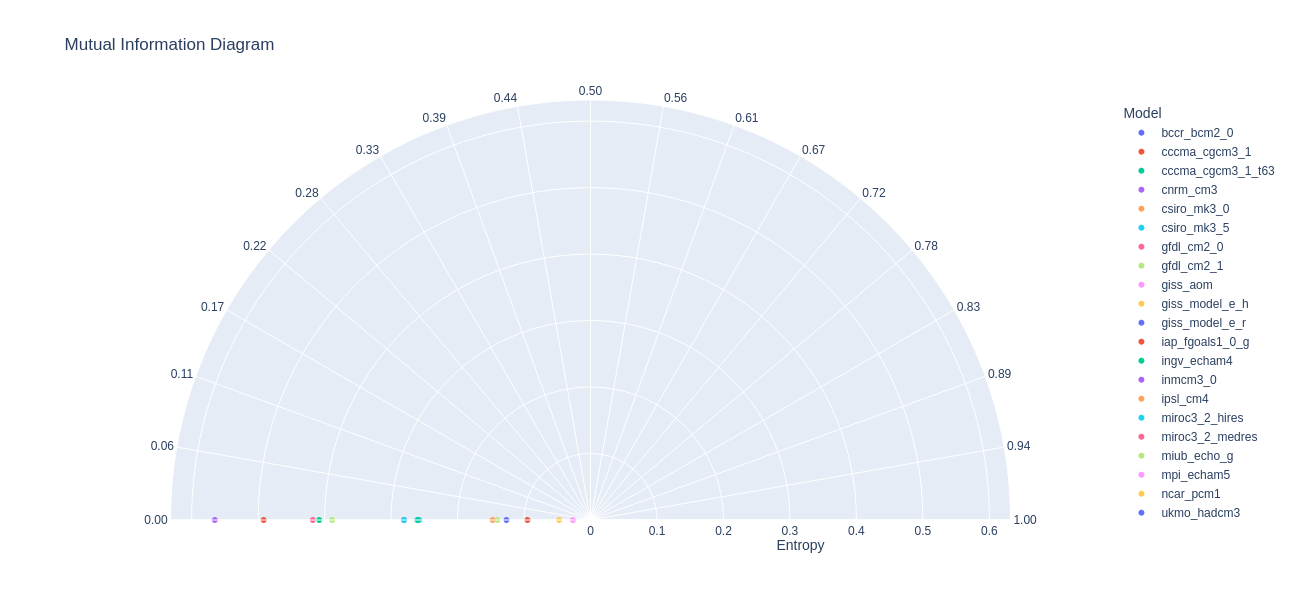

In [206]:
chart_mi_res = chart_create_mid(df_dataset_1_mid, 'bccr_bcm2_0', string_type=string_type_mid)
chart_mi_res.show()

In [207]:
df_dataset_1_td = calculate_td_properties (df_dataset_1_pivoted, 'bccr_bcm2_0')
df_dataset_1_td

,Model,STD,Correlation,Angle,Normalized_STD
0,bccr_bcm2_0,0.151468,1.000000,0.000000,1.000000
1,cccma_cgcm3_1,0.423239,0.447744,63.400940,2.794250
2,cccma_cgcm3_1_t63,0.428192,0.408067,65.916517,2.826955
3,cnrm_cm3,0.383088,0.231036,76.641935,2.529172
4,csiro_mk3_0,0.218696,0.456389,62.845662,1.443843
5,csiro_mk3_5,0.331178,0.434916,64.220078,2.186457
6,gfdl_cm2_0,0.341074,0.246686,75.718534,2.251791
7,gfdl_cm2_1,0.330288,0.250612,75.486247,2.180585
8,giss_aom,0.299807,0.407816,65.932268,1.979344
9,giss_model_e_h,0.192920,0.327887,70.859409,1.273673


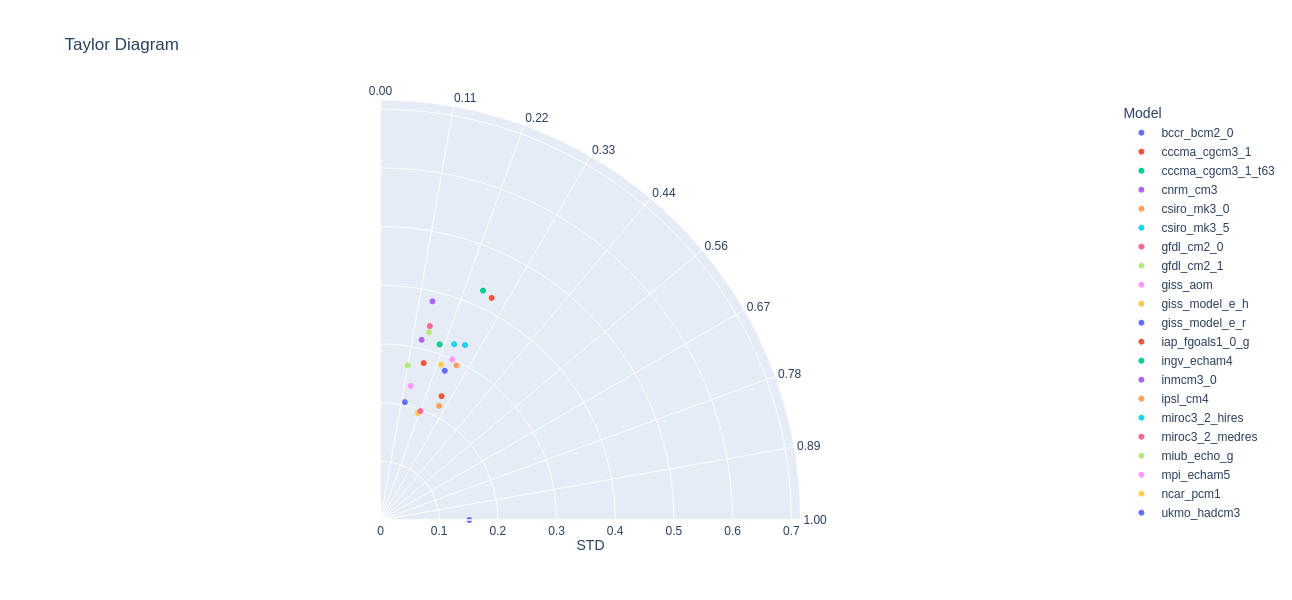

In [208]:
chart_td_res = chart_create_td(df_dataset_1_td, 'bccr_bcm2_0')
chart_td_res.show()

In [209]:
def test_dataset_2():
    path_root_data = os.path.join('..', 'Data')
    path_dataset_2 = os.path.join(path_root_data, 'Dataset_2', 'Splitted_files')
    
    df_result = pd.DataFrame()
    list_dataset_names = []
    
    for string_one_table in os.listdir(path_dataset_2):
        path_one_dataset = os.path.join(path_dataset_2, string_one_table)
        string_one_dataset_name = string_one_table.split('_')[2]
        
        df_one_dataset = pd.read_csv(path_one_dataset)
        df_result = pd.concat([df_result, df_one_dataset], ignore_index=True)
        
        list_dataset_names += [string_one_dataset_name] * df_one_dataset.shape[0]
        
    df_result['Dataset'] = list_dataset_names
    
    return df_result

test_dataset_2()

,Method,Parameters,Phi (μ),"IN (T,Z)",H (T|Z),Dataset
0,FCM-I-fs,"c=3,σ=0.6,m=1.20","0.947,0.000 (8.0,0.0)","0.845,0.000","0.172,0.000",Iris
1,FCM-II-fs,"c=3,σ=0.6,λ=0.1","0.923,0.017 (11.5,2.6)","0.810,0.024","0.214,0.029",Iris
2,FCM-I-km,"c=3,σ=3,m=2.4","0.907,0.000 (14.0,0.0)","0.766,0.000","0.260,0.000",Iris
3,FCM-II-km,"c=3,σ=5,λ=0.2","0.913,0.000 (13.0,0.0)","0.745,0.000","0.283,0.000",Iris
4,SVC,"c=3,C=1,σ=0.35","0.680,0.000 (48.0,0.0)","0.736,0.000","0.453,0.000",Iris
5,FCM-I,"c=3,m=2.4","0.900,0.000 (15.0,0.0)","0.758,0.000","0.270,0.000",Iris
6,FCM-II,"c=3,λ=5.4","0.913,0.000 (13.0,0.0)","0.745,0.000","0.283,0.000",Iris
7,K-means,c=3,"0.860,0.083 (21.1,12.5)","0.733,0.061","0.309,0.087",Iris
8,FCM-I-fs,"-c=6,σ=1,m=1.4","0.623,0.019 (80.8,4.1)","0.408,0.006","0.856,0.013",Glass
9,FCM-II-fs,"c=6,σ=0.8,λ=0.2","0.624,0.010 (80.5,2.2)","0.381,0.012","0.898,0.018",Glass
